In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
from PIL import Image
import natsort
import cv2
from loguru import logger
from sklearn.model_selection import train_test_split

In [2]:
DATASET_VERSION = "V2"
BASE_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}"
input_train = pd.read_csv(os.path.join(BASE_DIR, 'train/input.csv'))
target_train = pd.read_csv(os.path.join(BASE_DIR, 'train/target.csv'))

input_val = pd.read_csv(os.path.join(BASE_DIR, 'val/input.csv'))
target_val = pd.read_csv(os.path.join(BASE_DIR, 'val/target.csv'))

input_test = pd.read_csv(os.path.join(BASE_DIR, 'test/input.csv'))
target_test = pd.read_csv(os.path.join(BASE_DIR, 'test/target.csv'))

In [3]:
target_train

,id_key,Name,S3Path,Footprint,GeoFootprint,cloud_cover
0,S2A_MSIL1C_20180102T102421_N0500_R065_T32TMT,S2A_MSIL2A_20180102T102421_N0500_R065_T32TMT_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/02/S2...,geography'SRID=4326;POLYGON ((7.75237634651315...,"{'type': 'Polygon', 'coordinates': [[[7.752376...",68.546486
1,S2A_MSIL1C_20180102T102421_N0500_R065_T32UPU,S2A_MSIL2A_20180102T102421_N0500_R065_T32UPU_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/02/S2...,geography'SRID=4326;POLYGON ((10.3602792462837...,"{'type': 'Polygon', 'coordinates': [[[10.36027...",94.254524
2,S2A_MSIL1C_20180102T102421_N0500_R065_T32UPV,S2A_MSIL2A_20180102T102421_N0500_R065_T32UPV_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/02/S2...,geography'SRID=4326;POLYGON ((10.3851737331767...,"{'type': 'Polygon', 'coordinates': [[[10.38517...",99.120772
3,S2A_MSIL1C_20180102T102421_N0500_R065_T32UMU,S2A_MSIL2A_20180102T102421_N0500_R065_T32UMU_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/02/S2...,geography'SRID=4326;POLYGON ((8.07866651500257...,"{'type': 'Polygon', 'coordinates': [[[8.078666...",59.879202
4,S2A_MSIL1C_20180102T102421_N0500_R065_T32UMV,S2A_MSIL2A_20180102T102421_N0500_R065_T32UMV_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/02/S2...,geography'SRID=4326;POLYGON ((8.41368654470404...,"{'type': 'Polygon', 'coordinates': [[[8.413686...",79.515254
...,...,...,...,...,...,...
4795,S2C_MSIL1C_20250227T103021_N0511_R108_T31UGR,S2C_MSIL2A_20250227T103021_N0511_R108_T31UGR_2...,/eodata/Sentinel-2/MSI/L2A/2025/02/27/S2C_MSIL...,geography'SRID=4326;POLYGON ((6.21294280425978...,"{'type': 'Polygon', 'coordinates': [[[6.212942...",61.055893
4796,S2C_MSIL1C_20250227T103021_N0511_R108_T31UGP,S2C_MSIL2A_20250227T103021_N0511_R108_T31UGP_2...,/eodata/Sentinel-2/MSI/L2A/2025/02/27/S2C_MSIL...,geography'SRID=4326;POLYGON ((5.68779703536694...,"{'type': 'Polygon', 'coordinates': [[[5.687797...",63.414717
4797,S2B_MSIL1C_20250228T104909_N0511_R051_T31UFP,S2B_MSIL2A_20250228T104909_N0511_R051_T31UFP_2...,/eodata/Sentinel-2/MSI/L2A/2025/02/28/S2B_MSIL...,geography'SRID=4326;POLYGON ((5.04386674293589...,"{'type': 'Polygon', 'coordinates': [[[5.043866...",80.642426
4798,S2B_MSIL1C_20250301T101849_N0511_R065_T32TNS,S2B_MSIL2A_20250301T101849_N0511_R065_T32TNS_2...,/eodata/Sentinel-2/MSI/L2A/2025/03/01/S2B_MSIL...,geography'SRID=4326;POLYGON ((8.99973715756221...,"{'type': 'Polygon', 'coordinates': [[[8.999737...",50.229102


In [4]:
logger.info(f" TRAIN  L1C product:  {len(input_train)}")
logger.info(f"TRAIN L2A product {len(target_train)}")

logger.info(f"VAL L1C product:  {len(input_val)}")
logger.info(f"VAL L2A product {len(target_val)}")

logger.info(f"TEST L1C product:  {len(input_test)}")
logger.info(f"TEST L2A product {len(target_test)}")

2025-04-28 10:18:28.790 | INFO     | __main__:<module>:1 -  TRAIN  L1C product:  4800
2025-04-28 10:18:28.793 | INFO     | __main__:<module>:2 - TRAIN L2A product 4800
2025-04-28 10:18:28.794 | INFO     | __main__:<module>:4 - VAL L1C product:  600
2025-04-28 10:18:28.795 | INFO     | __main__:<module>:5 - VAL L2A product 600
2025-04-28 10:18:28.795 | INFO     | __main__:<module>:7 - TEST L1C product:  600
2025-04-28 10:18:28.796 | INFO     | __main__:<module>:8 - TEST L2A product 600


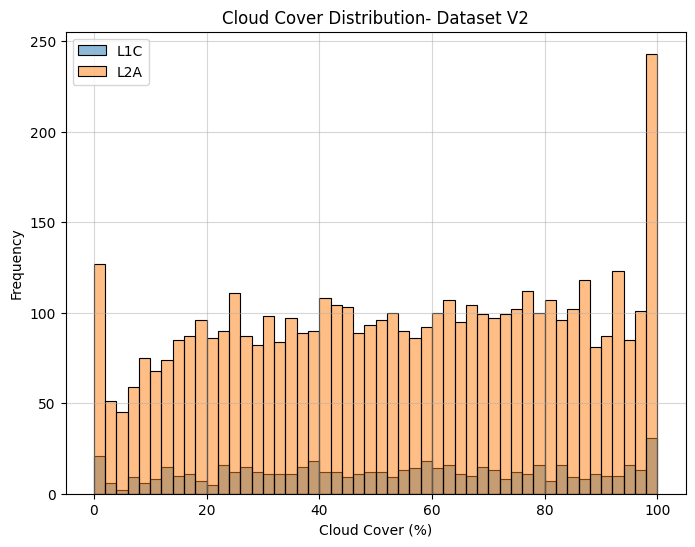

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms of cloud_cover
plt.figure(figsize=(8, 6))
sns.histplot(target_test['cloud_cover'], bins=50, label='L1C', alpha=0.5)
sns.histplot(target_train['cloud_cover'], bins=50,label='L2A', alpha=0.5)
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.title(f'Cloud Cover Distribution- Dataset {DATASET_VERSION}')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

def extract_date_info(df, id_column='id_key'):
    """
    Extract date information from the given dataframe.

    Args:
        df (pd.DataFrame): Input dataframe.
        id_column (str): Column name containing the ID string.

    Returns:
        pd.DataFrame: Dataframe with additional date columns.
    """
    # Extract date from id_key
    def extract_date_from_id(id_key):
        """Extract the date part (YYYYMMDD) from Sentinel-2 ID string"""
        match = re.search(r'_(\d{8})T', id_key)
        if match:
            return match.group(1)
        return None

    # Apply the extraction to the dataframe
    df['date_str'] = df[id_column].apply(extract_date_from_id)

    # Convert to datetime and extract month information
    df['date'] = pd.to_datetime(df['date_str'], format='%Y%m%d')
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.strftime('%b')
    df['year_month'] = df['date'].dt.strftime('%Y-%m')

    return df


def plot_monthly_distribution(df):
    """
    Create bar plots for data counts per month and year-month.

    Args:
        df (pd.DataFrame): Input dataframe with date information.

    Returns:
        None
    """
    # Create a count of data points by month
    monthly_counts = df['month_name'].value_counts().sort_index()

    # Sort the months in chronological order
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_counts = monthly_counts.reindex(month_order)

    # Create a bar plot for data counts per month
    plt.figure(figsize=(18, 6))
    monthly_counts.plot(kind='bar', color=sns.color_palette("viridis", len(monthly_counts)))
    plt.xlabel('Month')
    plt.ylabel('Number of Data Points')
    plt.title('Distribution of Data by Month')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on top of bars
    for i, count in enumerate(monthly_counts):
        plt.text(i, count + (max(monthly_counts) * 0.02), str(count), ha='center')

    plt.tight_layout()
    plt.show()

    # For a more detailed view, you could also plot by year-month
    # (if your data spans multiple years)
    yearly_monthly_counts = df['year_month'].value_counts().sort_index()

    plt.figure(figsize=(18, 6))
    yearly_monthly_counts.plot(kind='bar', color=sns.color_palette("mako", len(yearly_monthly_counts)))
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Data Points')
    plt.title('Distribution of Data by Year and Month')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on top of bars
    for i, count in enumerate(yearly_monthly_counts):
        plt.text(i, count + (max(yearly_monthly_counts) * 0.01), str(count), ha='center')

    plt.tight_layout()
    plt.show()

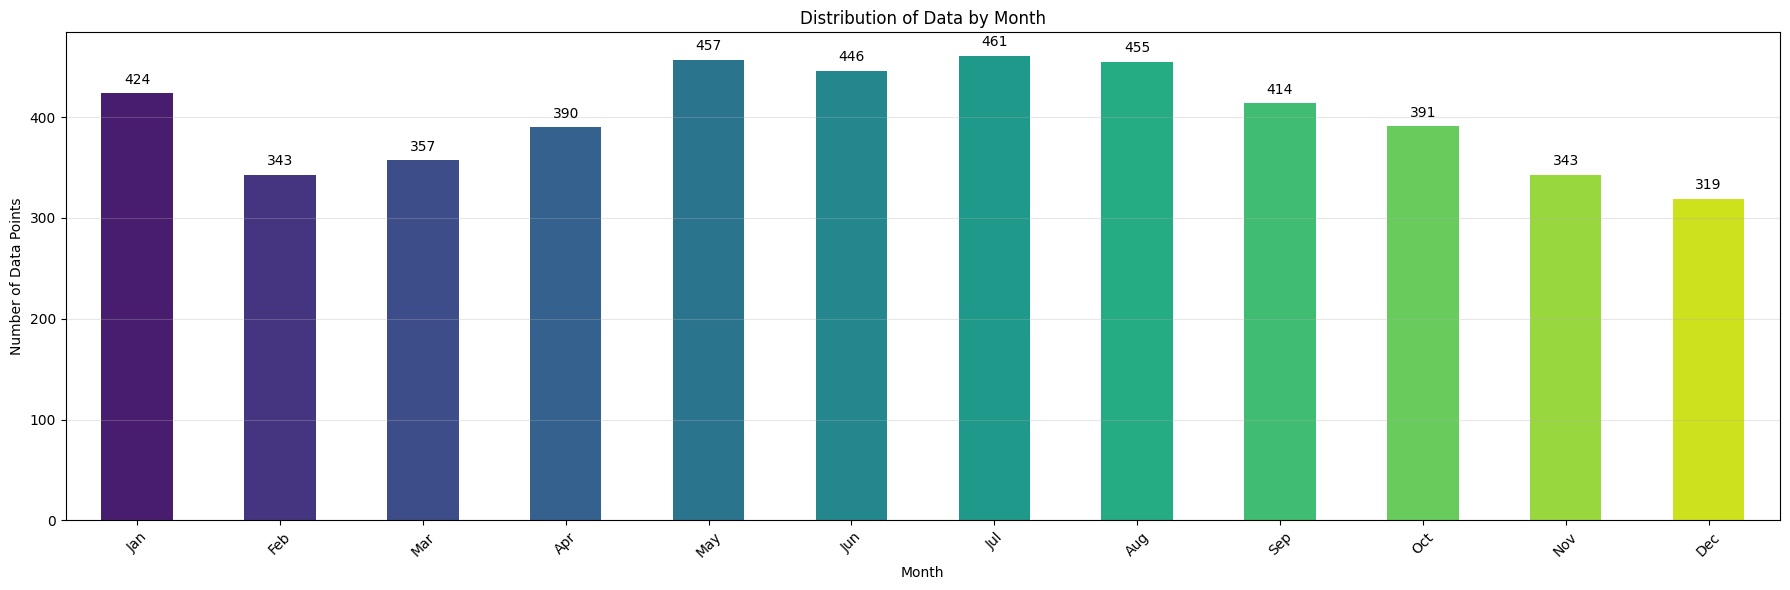

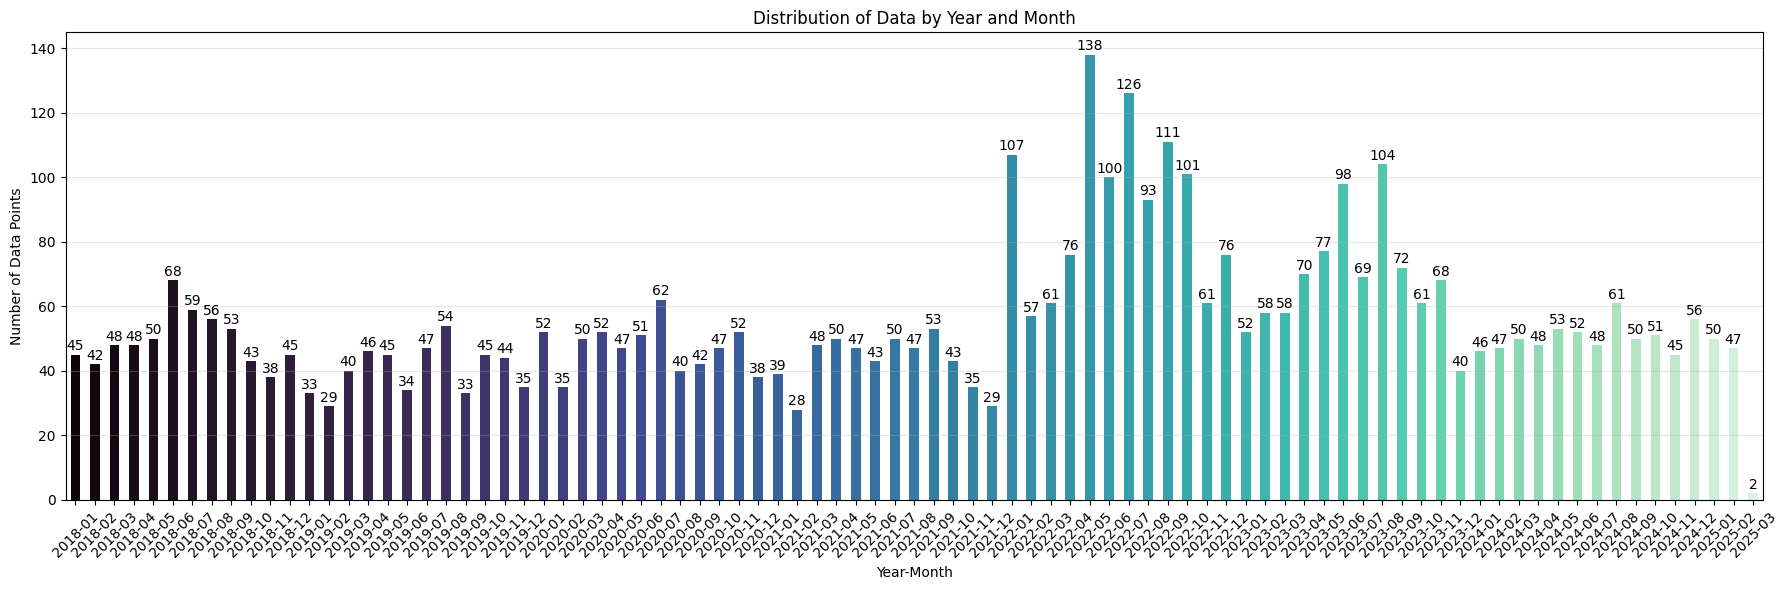

In [23]:
target_train = extract_date_info(target_train)
plot_monthly_distribution(target_train)

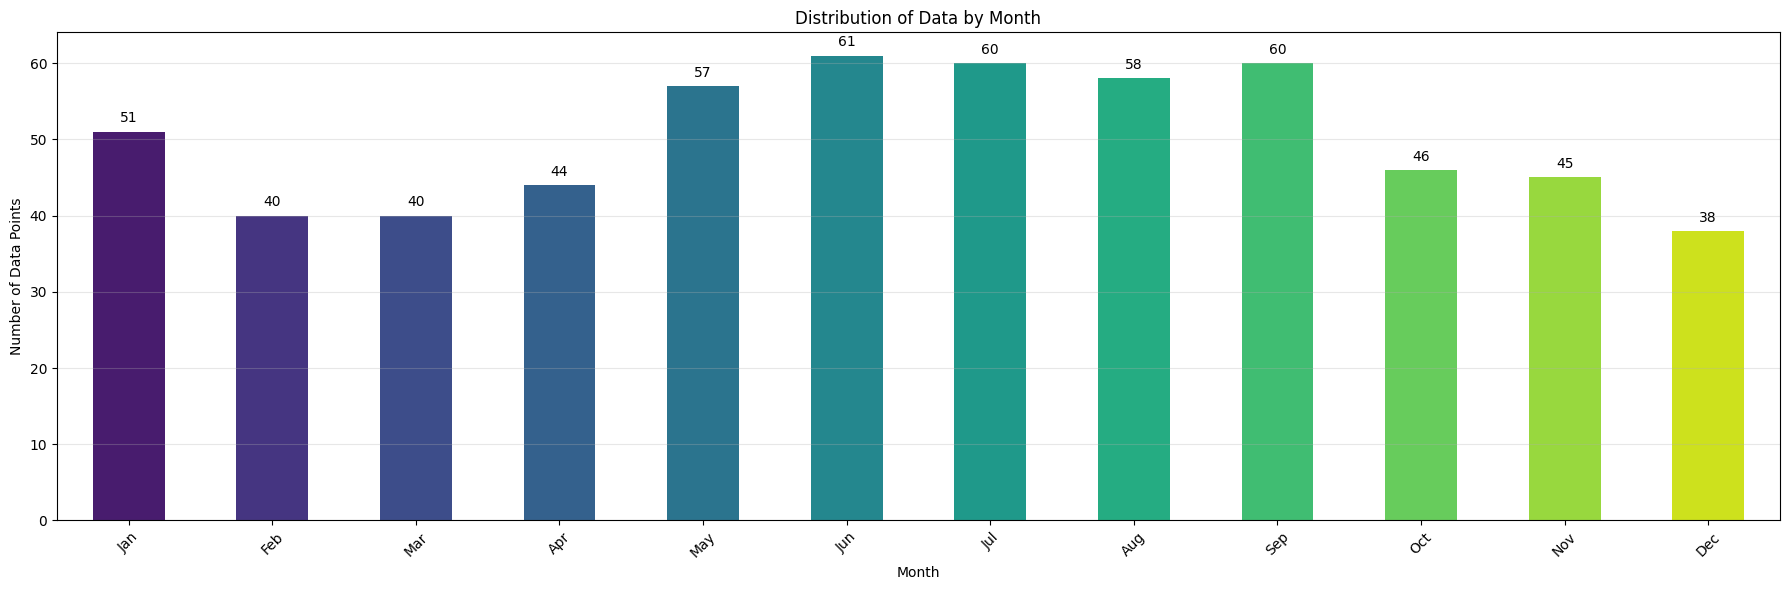

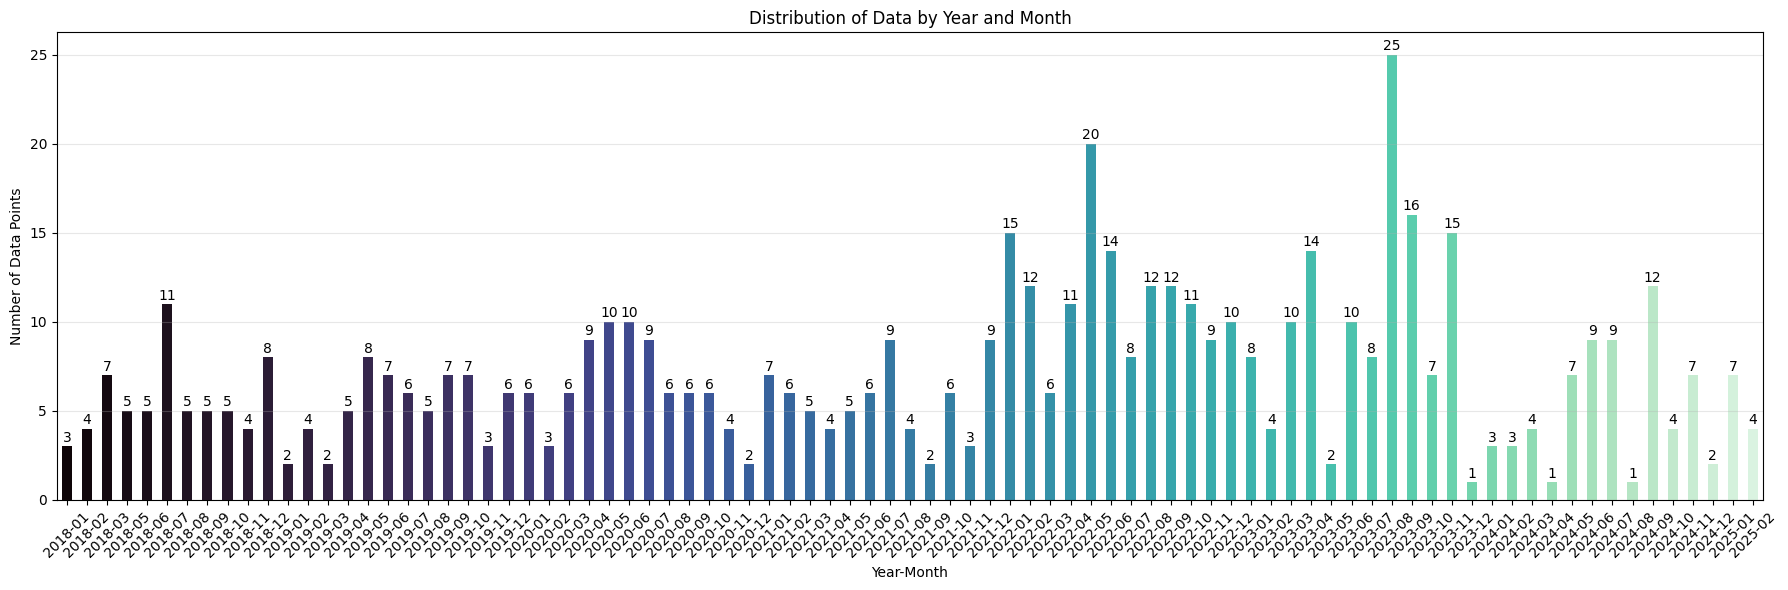

In [24]:
target_val = extract_date_info(target_val)
plot_monthly_distribution(target_val)

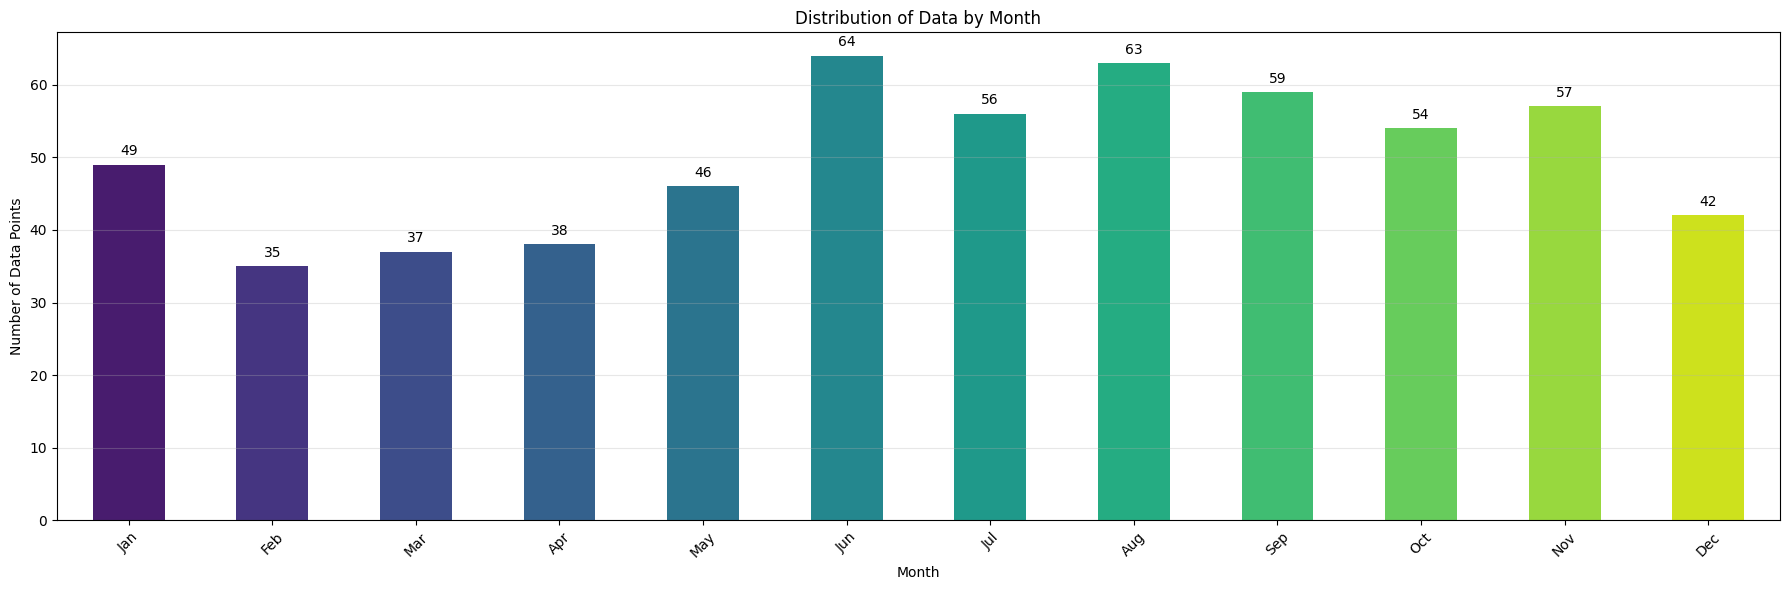

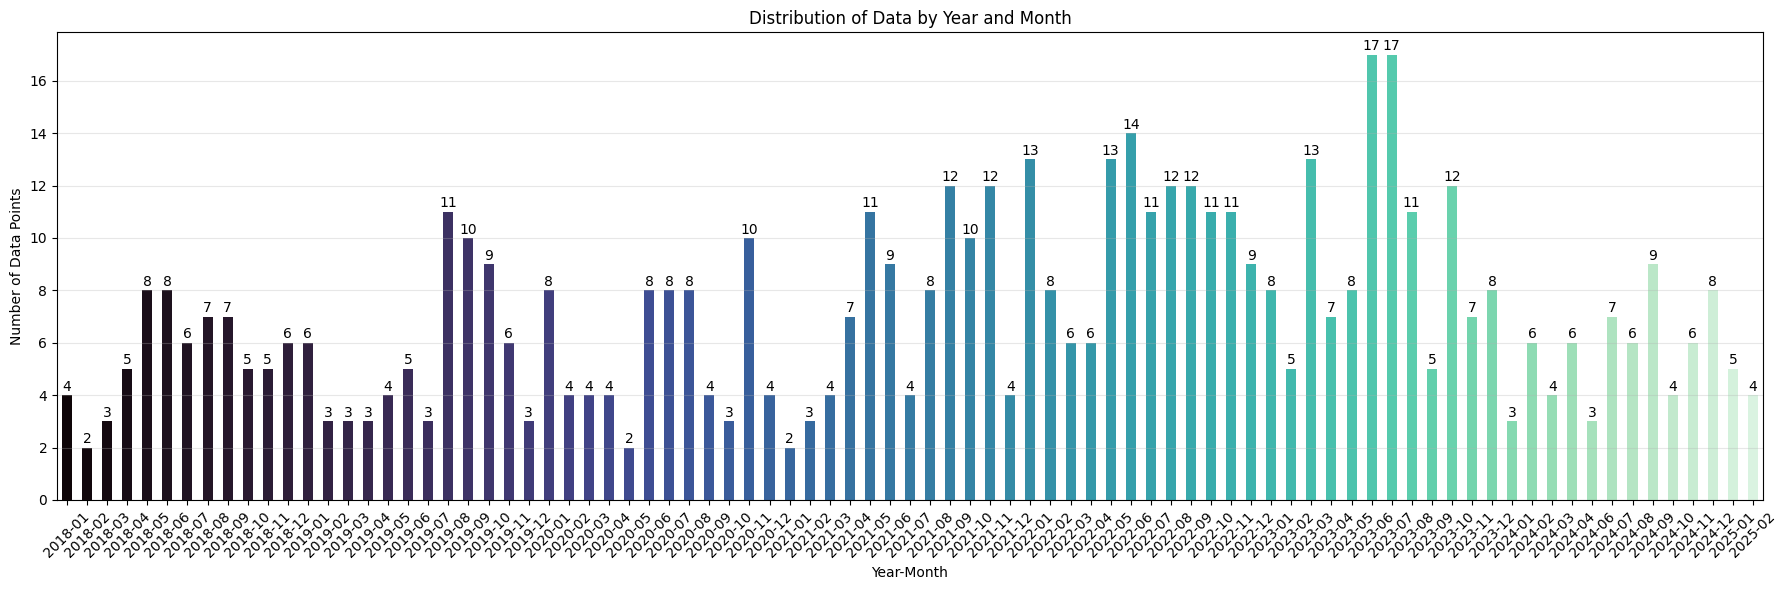

In [25]:
target_test = extract_date_info(target_test)
plot_monthly_distribution(target_test)

In [26]:
for i in range(min(len(input_val), len(target_val))):
    if not input_val['id_key'][i] == target_val['id_key'][i]:
        print(f"Mismatch: {input_val['id_key'][i]} == {target_val['id_key'][i]}")

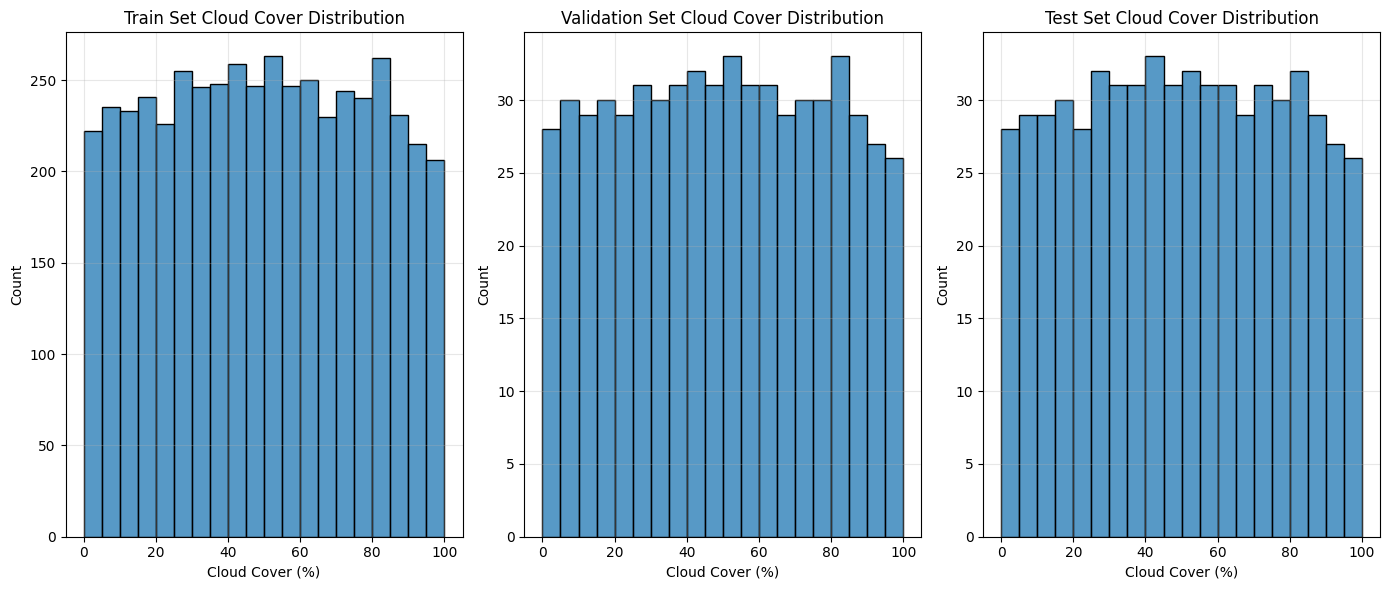

In [27]:
# Visualize cloud cover distribution across splits
plt.figure(figsize=(14, 6))

# Plot histograms for each split
plt.subplot(1, 3, 1)
sns.histplot(input_train['cloud_cover'], bins=20)
plt.title('Train Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
sns.histplot(input_val['cloud_cover'], bins=20)
plt.title('Validation Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
sns.histplot(input_test['cloud_cover'], bins=20)
plt.title('Test Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1800x600 with 0 Axes>

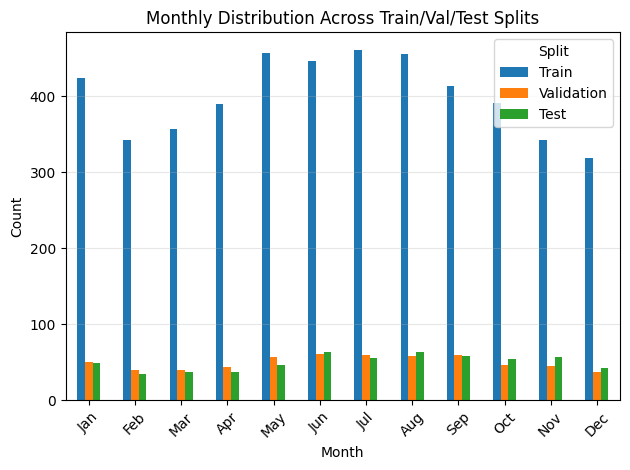

In [28]:
# Compare month distribution across splits
def plot_monthly_distribution_by_split(train_df, val_df, test_df, title='Monthly Distribution by Split'):
    """Plot monthly distribution across train/val/test splits"""
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    train_months = train_df['month_name'].value_counts().reindex(month_order).fillna(0)
    val_months = val_df['month_name'].value_counts().reindex(month_order).fillna(0)
    test_months = test_df['month_name'].value_counts().reindex(month_order).fillna(0)

    # Combine into a DataFrame for plotting
    monthly_dist = pd.DataFrame({
        'Train': train_months,
        'Validation': val_months,
        'Test': test_months
    })

    # Plot
    plt.figure(figsize=(18, 6))
    monthly_dist.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Split')
    plt.tight_layout()
    plt.show()

    return monthly_dist

# Plot monthly distribution




monthly_dist = plot_monthly_distribution_by_split(target_train, target_val, target_test, title='Monthly Distribution Across Train/Val/Test Splits')

In [ ]:
def normalize(band, lower_percent=2, upper_percent=98):
    """
    Apply percentile stretching to enhance contrast, only considering valid pixels.

    Args:
        band: Input image band as numpy array
        lower_percent: Lower percentile boundary (default 2%)
        upper_percent: Upper percentile boundary (default 98%)

    Returns:
        Normalized band with values in [0, 1]
    """
    # Create mask for valid pixels
    valid_mask = (band > 0)

    # If no valid pixels, return zeros
    if not np.any(valid_mask):
        return np.zeros_like(band, dtype=np.float32)

    # Extract valid pixels for percentile calculation
    valid_pixels = band[valid_mask]
    # Calculate percentiles based only on valid pixels
    lower = np.percentile(valid_pixels, lower_percent)
    upper = np.percentile(valid_pixels, upper_percent)

    # Create a copy to avoid modifying the original
    result = band.copy().astype(np.float32)

    # Apply stretching only to valid pixels
    result[valid_mask] = np.clip((band[valid_mask] - lower) / (upper - lower), 0, 1)

    # Set invalid pixels to 0
    result[~valid_mask] = 0

    return result



def read_images(product_paths):

    images = []

    for path in product_paths:

        print(path)

        data = Image.open(path)
        data = np.array(data)
        data = normalize(data)
        images.append(data)

    images = np.dstack(images)

    return images


Selected random sample index: 3789
/mnt/disk/dataset/sentinel-ai-processor/V2/train/input/S2A_MSIL1C_20230810T103631_N0509_R008_T31UFP_20230810T155915/T31UFP_20230810T103631_B02.png
/mnt/disk/dataset/sentinel-ai-processor/V2/train/input/S2A_MSIL1C_20230810T103631_N0509_R008_T31UFP_20230810T155915/T31UFP_20230810T103631_B03.png
/mnt/disk/dataset/sentinel-ai-processor/V2/train/input/S2A_MSIL1C_20230810T103631_N0509_R008_T31UFP_20230810T155915/T31UFP_20230810T103631_B04.png
/mnt/disk/dataset/sentinel-ai-processor/V2/train/target/S2A_MSIL2A_20230810T103631_N0509_R008_T31UFP_20230810T181759/T31UFP_20230810T103631_B02_10m.png
/mnt/disk/dataset/sentinel-ai-processor/V2/train/target/S2A_MSIL2A_20230810T103631_N0509_R008_T31UFP_20230810T181759/T31UFP_20230810T103631_B03_10m.png
/mnt/disk/dataset/sentinel-ai-processor/V2/train/target/S2A_MSIL2A_20230810T103631_N0509_R008_T31UFP_20230810T181759/T31UFP_20230810T103631_B04_10m.png


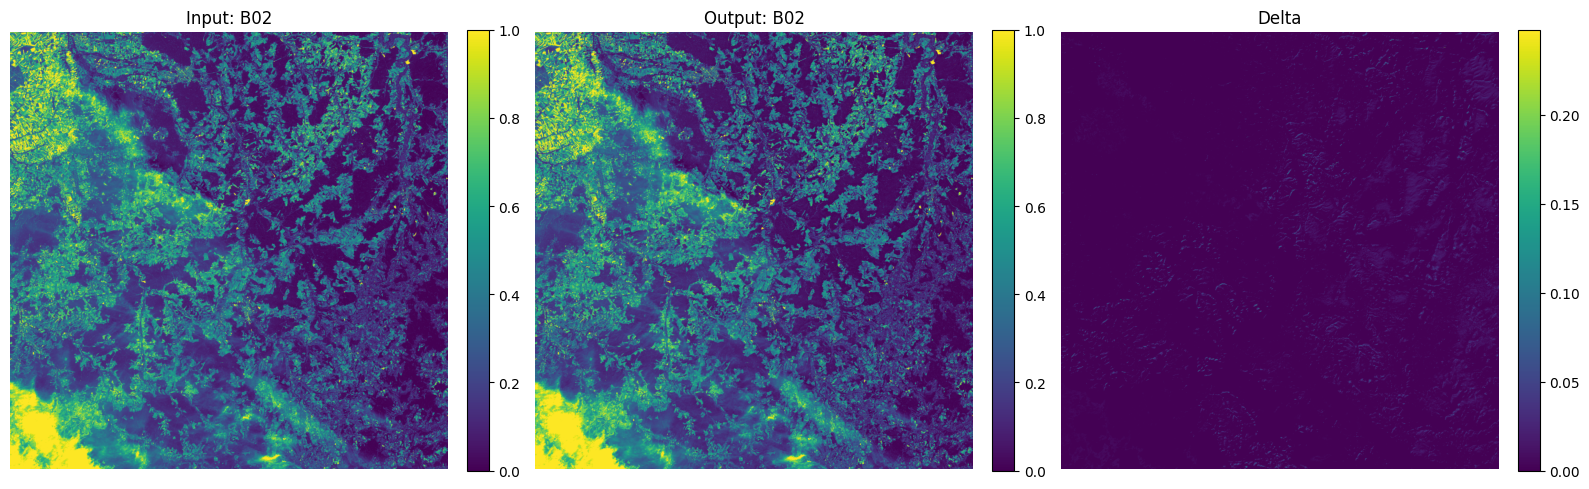

In [ ]:
import random
import os
import glob
import natsort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def prepare_paths(path_dir):
    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")
    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))
    return df_input, df_output

DATASET_VERSION = "V2"
TRAIN_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/train/"
VAL_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/val/"
TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/test/"

df_train_input, df_train_output = prepare_paths(TRAIN_DIR)
df_val_input, df_val_output = prepare_paths(VAL_DIR)
df_test_input, df_test_output = prepare_paths(TEST_DIR)

# Choose a random index
random_idx = random.randint(0, len(df_train_input) - 1)
print(f"Selected random sample index: {random_idx}")
x_paths = natsort.natsorted(glob.glob(os.path.join(df_train_input["path"][random_idx], "*.png"), recursive=False))
x_data = read_images(x_paths)

y_paths = natsort.natsorted(glob.glob(os.path.join(df_train_output["path"][random_idx], "*.png"), recursive=False))
y_data = read_images(y_paths)



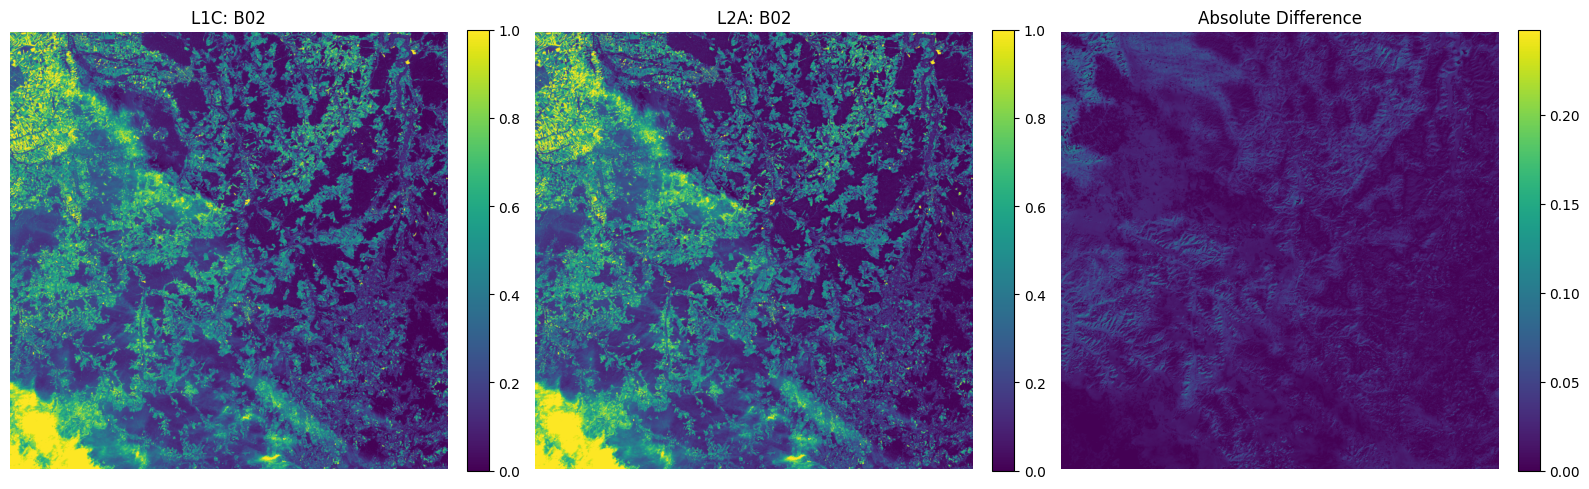

In [85]:
# Calculate delta and clip values between 0 and 1
delta = np.abs(y_data[:,:,0] - x_data[:,:,0])
delta_clipped = np.clip(delta, 0, 1)  # Clip values to be between 0 and 1
# Display input, output and delta side by side
plt.figure(figsize=(16, 5))

# Input image
ax1 = plt.subplot(1, 3, 1)
im1 = ax1.imshow(x_data[:,:,0])
plt.title("L1C: B02")
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.axis('off')

# Output image
ax2 = plt.subplot(1, 3, 2)
im2 = ax2.imshow(y_data[:,:,0])
plt.title("L2A: B02")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.axis('off')

# Delta image
ax3 = plt.subplot(1, 3, 3)
im3 = ax3.imshow(delta_clipped)
plt.title("Absolute Difference")
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
ax3.axis('off')

plt.tight_layout()
plt.show()